In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import os
import time

print(tf.__version__)
from tensorflow.keras import optimizers, metrics, losses
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from keras.initializers import RandomNormal

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from tensorflow.keras.layers import Conv1D,MaxPooling1D,Conv1DTranspose,AveragePooling1D,GlobalMaxPool1D,GlobalAveragePooling1D
from tensorflow.keras.layers import Conv2D,MaxPool2D,Conv2DTranspose,AveragePooling2D,GlobalMaxPool2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv3D,MaxPooling3D,Conv3DTranspose,AveragePooling3D,GlobalMaxPool3D,GlobalAveragePooling3D
from tensorflow.keras.layers import Dense,Flatten,Dropout,Concatenate,Layer,BatchNormalization,Input,Add,Activation,Average

from tensorflow.keras import layers

2.10.1


In [2]:
#data_path = "outlineOutput"
#data_path = "H:\\download\\blender\\projects\\vdmTests\\outlineOutput"
#output_path = "H:\\tmp\\dexined"

data_path = "I:\\tmp\\datasets\\tinyDexinedDataset"
output_path = "I:\\tmp\\teed"

train_path = data_path + "/train/*"
edge_train_path = data_path + "/train_edge/*"

test_path = data_path + "/test/*"
edge_test_path = data_path + "/test_edge/*"

val_path = data_path + "/val/*"
edge_val_path = data_path + "/val_edge/*"

print(edge_test_path)


I:\tmp\datasets\tinyDexinedDataset/test_edge/*


In [3]:
def load_data(ipath, epath):
    images = sorted(glob(os.path.join(ipath)))
    edges = sorted(glob(os.path.join(epath)))
    return images, edges

In [4]:
images, edges = load_data(train_path, edge_train_path)
valimg, valedg = load_data(val_path, edge_val_path)
#print(len(images), len(edges))

In [5]:
#print(len(testimg), len(testedg))

In [5]:
def read_image(path, H=512, W=912):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W,H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_edge(path, H=512, W=912):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W,H))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    x = x.astype(np.float32)
    return x

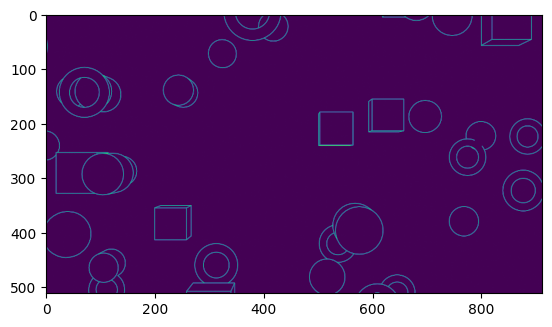

In [6]:

img = read_edge(data_path+"/train_edge/dense_000.png", H=512, W=912)
plt.imshow(img)

In [7]:
def preprocess(x,y,H=512, W=912):

    def f(x,y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_edge(y)
        return x, y

    images, edges = tf.numpy_function(f, [x, y], [tf.float32, tf.float32])
    images.set_shape([H, W, 3])
    edges.set_shape([H, W, 1])
    return images, edges

In [8]:
def tf_data(x,y):
    data = tf.data.Dataset.from_tensor_slices((x,y))
    data = data.shuffle(buffer_size=100)
    data = data.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    data = data.batch(2)
    data = data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return data


In [9]:
train_data = tf_data(images, edges)
val_data = tf_data(valimg, valedg)

In [10]:
#for x, y in train_data:
#  print(x.shape, y.shape)
#
print(len(train_data),len(val_data))


100 19


In [11]:
@tf.function
def smish(input):
    return input * tf.math.tanh(tf.math.log(1+tf.math.sigmoid(input)))

class Smish(layers.Layer):

    def __init__(self):
        """
        Init method.
        """
        super().__init__()

    def call(self, input):
        """
        Forward pass of the function.
        """
        return smish(input)

In [12]:
weight_init = tf.initializers.glorot_uniform()

l2 = regularizers.l2
w_decay=1e-3

glorot_normal = RandomNormal(stddev=0.01)

orthogonal = tf.keras.initializers.Orthogonal(
    gain=1.0, seed=None
)

In [13]:
self_conv2D_1 = Conv2D(16 , kernel_size=(3,3),strides=(2,2),padding = 'same',use_bias=True,kernel_initializer= glorot_normal)
self_conv2D_11 = Conv2D(16 , kernel_size=(3,3),strides=(1,1),padding = 'same',use_bias=True,kernel_initializer= glorot_normal)
self_conv2D_17 = Conv2D(32 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_conv2D_18 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',activation='relu',use_bias=True,kernel_initializer= glorot_normal)
self_conv2D_19 = Conv2D(32 , kernel_size=(1,1),strides=(2,2),padding = 'same')
self_conv2D_12 = Conv2D(32 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_transpoze2D_1 = Conv2DTranspose(1 , kernel_size=(2,2),strides=(2,2),padding = 'same',use_bias=True,kernel_initializer= glorot_normal)
self_conv2D_5 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',activation='relu',use_bias=True,kernel_initializer= glorot_normal)
self_maxpool2D_1 = MaxPool2D(pool_size=(3,3),strides=(2,2),padding = 'same')
self_conv2D_24 = Conv2D(48 , kernel_size=(1,1),strides=(1,1),padding = 'same')
self_transpoze2D_4 = Conv2DTranspose(1 , kernel_size=(2,2),strides=(2,2),padding = 'same',use_bias=True,kernel_initializer= glorot_normal)
self_conv2D_2 = Conv2D(32 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_conv2D_3 = Conv2D(48 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_conv2D_20 = Conv2D(16 , kernel_size=(1,1),strides=(1,1),padding = 'same',activation='relu',use_bias=True,kernel_initializer= glorot_normal)
self_transpoze2D_2 = Conv2DTranspose(16 , kernel_size=(2,2),strides=(2,2),padding = 'same',use_bias=True,kernel_initializer= glorot_normal)
self_conv2D_21 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',activation='relu',use_bias=True,kernel_initializer= glorot_normal)
self_transpoze2D_3 = Conv2DTranspose(1 , kernel_size=(4,4),strides=(2,2),padding = 'same',use_bias=True,kernel_initializer= glorot_normal)
self_concatenate_1 = Concatenate(axis=3)
self_conv2D_22 = Conv2D(24 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_conv2D_23 = Conv2D(24 , kernel_size=(3,3),strides=(1,1),padding = 'same')
self_conv2D_6 = Conv2D(24 , kernel_size=(3,3),strides=(1,1),padding = 'same',activation='relu')
self_concatenate_2 = Concatenate(axis=3)
self_conv2D_7 = Conv2D(24 , kernel_size=(3,3),strides=(1,1),padding = 'same',activation='relu')
self_concatenate_3 = Concatenate(axis=3)
self_conv2D_8 = Conv2D(24 , kernel_size=(3,3),strides=(1,1),padding = 'same',activation='relu')
self_concatenate_4 = Concatenate(axis=3)
self_conv2D_4 = Conv2D(24 , kernel_size=(3,3),strides=(1,1),padding = 'same',activation='relu')
self_conv2D_10 = Conv2D(32 , kernel_size=(3,3),strides=(1,1),padding = 'same',activation='relu',kernel_initializer= orthogonal)
self_conv2D_13 = Conv2D(32 , kernel_size=(3,3),strides=(1,1),padding = 'same',activation='relu')
self_concatenate_5 = Concatenate(axis=3)
self_conv2D_14 = Conv2D(32 , kernel_size=(3,3),strides=(1,1),padding = 'same',activation='relu')
self_concatenate_6 = Concatenate(axis=3)
self_conv2D_15 = Conv2D(32 , kernel_size=(3,3),strides=(1,1),padding = 'same',activation='relu')
self_concatenate_7 = Concatenate(axis=3)
self_conv2D_16 = Conv2D(32 , kernel_size=(3,3),strides=(1,1),padding = 'same',activation='relu')
self_conv2D_9 = Conv2D(1 , kernel_size=(1,1),strides=(1,1),padding = 'same',activation='relu',kernel_initializer= orthogonal)

self_activation_9=Smish()
self_activation_2=Smish()
self_activation_3=Smish()
self_activation_8=Smish()
self_activation_7=Smish()
self_activation_5=Smish()
self_activation_1=Smish()
self_activation_6=Smish()
self_activation_4=Smish()

x = Input(shape=(512,912,3))


conv2D_1 = self_conv2D_1(x)


activation_9 = self_activation_9(conv2D_1)
conv2D_11 = self_conv2D_11(activation_9)
activation_2 = self_activation_2(conv2D_11)
conv2D_17 = self_conv2D_17(activation_2)
conv2D_18 = self_conv2D_18(activation_2)
conv2D_19 = self_conv2D_19(activation_2)
activation_3 = self_activation_3(conv2D_17)
activation_8 = self_activation_8(conv2D_18)
conv2D_12 = self_conv2D_12(activation_3)
transpoze2D_1 = self_transpoze2D_1(activation_8)
conv2D_5 = self_conv2D_5(conv2D_12)
maxpool2D_1 = self_maxpool2D_1(conv2D_12)
activation_7 = self_activation_7(conv2D_5)
add_1 = Add()([conv2D_19,maxpool2D_1])
conv2D_24 = self_conv2D_24(maxpool2D_1)
transpoze2D_4 = self_transpoze2D_4(activation_7)
conv2D_2 = self_conv2D_2(add_1)
activation_5 = self_activation_5(conv2D_2)
conv2D_3 = self_conv2D_3(activation_5)
average_1 = Average()([conv2D_3,conv2D_24])
conv2D_20 = self_conv2D_20(average_1)
activation_1 = self_activation_1(conv2D_20)
transpoze2D_2 = self_transpoze2D_2(activation_1)
conv2D_21 = self_conv2D_21(transpoze2D_2)
activation_6 = self_activation_6(conv2D_21)
transpoze2D_3 = self_transpoze2D_3(activation_6)
concatenate_1_TMP = [transpoze2D_1,transpoze2D_3,transpoze2D_4]
concatenate_1 = self_concatenate_1(concatenate_1_TMP)
conv2D_22 = self_conv2D_22(concatenate_1)
conv2D_23 = self_conv2D_23(conv2D_22)
activation_4 = self_activation_4(conv2D_23)
conv2D_6 = self_conv2D_6(activation_4)
concatenate_2_TMP = [conv2D_23,conv2D_6]
concatenate_2 = self_concatenate_2(concatenate_2_TMP)
conv2D_7 = self_conv2D_7(concatenate_2)
concatenate_3_TMP = [concatenate_2,conv2D_7]
concatenate_3 = self_concatenate_3(concatenate_3_TMP)
conv2D_8 = self_conv2D_8(concatenate_3)
concatenate_4_TMP = [concatenate_2,concatenate_3,conv2D_8]
concatenate_4 = self_concatenate_4(concatenate_4_TMP)
conv2D_4 = self_conv2D_4(concatenate_4)


add_2 = Add()([conv2D_23,conv2D_4])


conv2D_10 = self_conv2D_10(add_2)
conv2D_13 = self_conv2D_13(conv2D_10)
concatenate_5_TMP = [conv2D_10,conv2D_13]
concatenate_5 = self_concatenate_5(concatenate_5_TMP)
conv2D_14 = self_conv2D_14(concatenate_5)
concatenate_6_TMP = [concatenate_5,conv2D_14]
concatenate_6 = self_concatenate_6(concatenate_6_TMP)
conv2D_15 = self_conv2D_15(concatenate_6)
concatenate_7_TMP = [concatenate_5,concatenate_6,conv2D_15]
concatenate_7 = self_concatenate_7(concatenate_7_TMP)
conv2D_16 = self_conv2D_16(concatenate_7)
add_3 = Add()([conv2D_10,conv2D_16])
conv2D_9 = self_conv2D_9(add_3)

#outputs = tf.nn.depth_to_space(conv2D_9, 1)
model = keras.Model(inputs =x , outputs=conv2D_9)


H:\download\anaconda3_envs\generativeTensorflowCudaV2\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
H:\download\anaconda3_envs\generativeTensorflowCudaV2\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 912, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 456, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 smish (Smish)                  (None, 256, 456, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                  'conv2d_transpose_1[0][0]']     
                                                                                                  
 conv2d_12 (Conv2D)             (None, 512, 912, 24  672         ['concatenate[0][0]']            
                                )                                                                 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 512, 912, 24  5208        ['conv2d_12[0][0]']              
                                )                                                                 
                                                                                                  
 smish_8 (Smish)                (None, 512, 912, 24  0           ['conv2d_13[0][0]']              
                                )                                                                 
          

In [15]:
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[tf.keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.FalseNegatives(),
             tf.keras.metrics.FalsePositives(),
             tf.keras.metrics.TruePositives(),
            tf.keras.metrics.TrueNegatives()])

In [16]:
model_filepath = output_path + "/model-{epoch:02d}-{val_binary_accuracy:.4f}.hdf5"

checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=False,
    verbose=1)
    

In [18]:
class GPUMemoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, target_batches, print_stats=False, **kwargs):
        """
        target_batches: A list of batch indices at which to record memory usage.
        print_stats: A boolean flag indicating whether to print memory usage statistics.
        """
        super().__init__(**kwargs)
        self.target_batches = target_batches
        self.print_stats = print_stats

        self.memory_usage = []
        self.labels = []

    def _compute_memory_usage(self):
        memory_stats = tf.config.experimental.get_memory_info("GPU:0")
        # Convert bytes to GB and store in list.
        peak_usage = round(memory_stats["peak"] / (2**30), 3)
        self.memory_usage.append(peak_usage)

    def on_epoch_begin(self, epoch, logs=None):
        self._compute_memory_usage()
        self.labels.append(f"epoch {epoch} start")

    def on_train_batch_begin(self, batch, logs=None):
        if batch in self.target_batches:
            self._compute_memory_usage()
            self.labels.append(f"batch {batch}")

    def on_epoch_end(self, epoch, logs=None):
        self._compute_memory_usage()
        self.labels.append(f"epoch {epoch} end")
        
gpu_memory_callback = GPUMemoryCallback(
    target_batches=[1, 2, 3],
    print_stats=True,
)

In [19]:
train_steps=len(train_data)
val_steps=len(val_data)
print(train_steps)
H = model.fit(train_data, validation_data=val_data, epochs=3, steps_per_epoch=train_steps, validation_steps=val_steps, callbacks=[checkpoint, gpu_memory_callback])

100
Epoch 1/3
100/100 [==============================] - ETA: 0s - loss: 0.1346 - binary_accuracy: 0.6431 - false_negatives: 33327120.0000 - false_positives: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 60061676.0000
Epoch 1: val_binary_accuracy improved from -inf to 0.64385, saving model to I:\tmp\teed\model-01-0.6439.hdf5
100/100 [==============================] - 62s 451ms/step - loss: 0.1346 - binary_accuracy: 0.6431 - false_negatives: 33327120.0000 - false_positives: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 60061676.0000 - val_loss: 0.1300 - val_binary_accuracy: 0.6439 - val_false_negatives: 6319400.0000 - val_false_positives: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 11424472.0000
Epoch 2/3
100/100 [==============================] - ETA: 0s - loss: 0.1346 - binary_accuracy: 0.6431 - false_negatives: 33327132.0000 - false_positives: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 60061660.0000
Epoch 2: val_binary_accu

<BarContainer object of 15 artists>

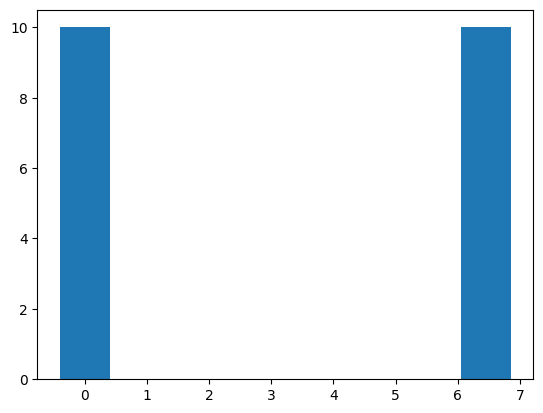

In [22]:
memory_usage = gpu_memory_callback.memory_usage
plt.bar(memory_usage,10)
#tf.config.experimental.reset_memory_stats("GPU:0")

In [21]:
memory_usage

[0.001,
 6.453,
 6.453,
 6.453,
 6.453,
 6.453,
 6.453,
 6.453,
 6.453,
 6.453,
 6.453,
 6.453,
 6.453,
 6.453,
 6.453]

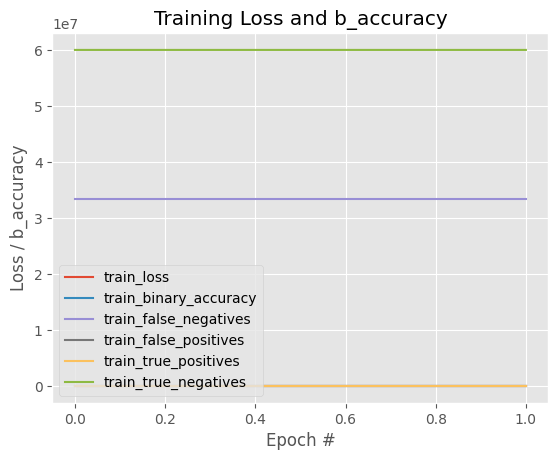

In [24]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["binary_accuracy"], label="train_binary_accuracy")
plt.plot(H.history["false_negatives"], label="train_false_negatives")
plt.plot(H.history["false_positives"], label="train_false_positives")
plt.plot(H.history["true_positives"], label="train_true_positives")
plt.plot(H.history["true_negatives"], label="train_true_negatives")
plt.title("Training Loss and b_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss / b_accuracy")
plt.legend(loc="lower left")

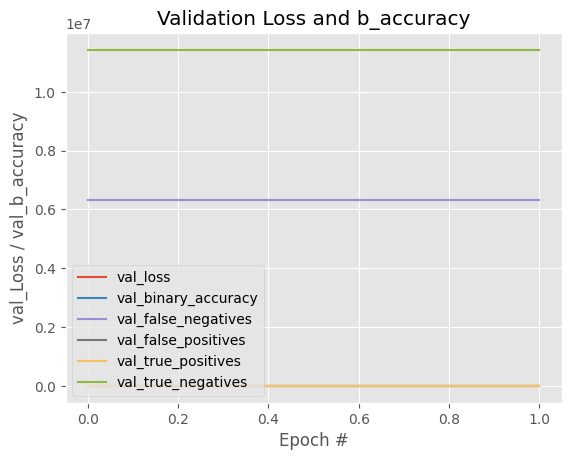

In [25]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["val_binary_accuracy"], label="val_binary_accuracy")
plt.plot(H.history["val_false_negatives"], label="val_false_negatives")
plt.plot(H.history["val_false_positives"], label="val_false_positives")
plt.plot(H.history["val_true_positives"], label="val_true_positives")
plt.plot(H.history["val_true_negatives"], label="val_true_negatives")
plt.title("Validation Loss and b_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("val_Loss / val_b_accuracy")
plt.legend(loc="lower left")

In [ ]:
img_pre = read_image('H:\\download\\blender\\projects\\vdmTests\\outlineOutput2\\test\\dense_981.png')
img = np.expand_dims(img_pre, axis=0)
plt.imshow(img_pre)

In [ ]:
img_e = read_image('H:\\download\\blender\\projects\\vdmTests\\outlineOutput2\\test_edge\\dense_981.png')
#img = np.expand_dims(img, axis=0)
plt.imshow(img_e)

In [ ]:
#model.load_weights("H:\\tmp\\dexined\\checkpoint_dir\\dexined_tryepochs\\DexiNed10_model.h5")
res_pre = model.predict(img)
res = res_pre[-1,:,:]
plt.imshow(res)

In [ ]:
def image_normalization(img, img_min=0, img_max=255):
    """This is a typical image normalization function
    where the minimum and maximum of the image is needed
    source: https://en.wikipedia.org/wiki/Normalization_(image_processing)
    :param img: an image could be gray scale or color
    :param img_min:  for default is 0
    :param img_max: for default is 255
    :return: a normalized image, if max is 255 the dtype is uint8
    """
    img = np.float32(img)
    epsilon=1e-12 # whenever an inconsistent image
    img = (img-np.min(img))*(img_max-img_min)/((np.max(img)-np.min(img))+epsilon)+img_min
    return img

In [ ]:
import cv2
res2=res
res2[res2 < 0.0] = 0.0
out=cv2.bitwise_not(np.uint8(image_normalization(res2)))
plt.imshow(out, cmap='gray')